In [1]:
import numpy as np

import numba

%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt

import auxiliary
import rotations

### Geometric properties

In [2]:
# length of the rod
#length = 0.1
length = 0.01

# diameter
#radius = 0.0005
radius = 5e-4

# cross-section area
A = np.pi * radius**2

# second moment of area
I = np.pi * radius**4 / 4

### Material properties

In [30]:
#def define_material():

# E-modulus
E = 200e9

# shear modulus
G = 80e9


# shearing stiffness
GA = G * A

# stretching stiffness
EA = E * A

# bending stiffness
EI = E * I

# twisting stiffness
GJ = 2 * G * I

# elasticity tensor
C = np.diag([GA, GA, EA, EI, EI, GJ])


# add bend-twist coupling
#C[4, 5] = C[5, 4] = GJ/10


#C = define_material()

### Dicretization properties

In [4]:
# number of elements
n_el = 100

# number of nodes
n_n = n_el + 1

# length of each element
h_vector = np.ones((n_el)) * (length / n_el)

### Solution variables

Declaration in global namespace and initialization as a undeformed reference configuration

In [5]:
def set_initial_conditions():
    # centerline displacement at each node
    centerline = np.zeros((3, n_n), dtype=float)
    for i in range(n_el):
        centerline[2, i+1] = centerline[2, i] + h_vector[i]

    # rotation of crosssection at each node,
    # axis-angle representation: 1 Euler vector per node
    rotation = np.zeros((3, n_n), dtype=float)
    
    return centerline, rotation

centerline, rotation = set_initial_conditions()

<IPython.core.display.Javascript object>


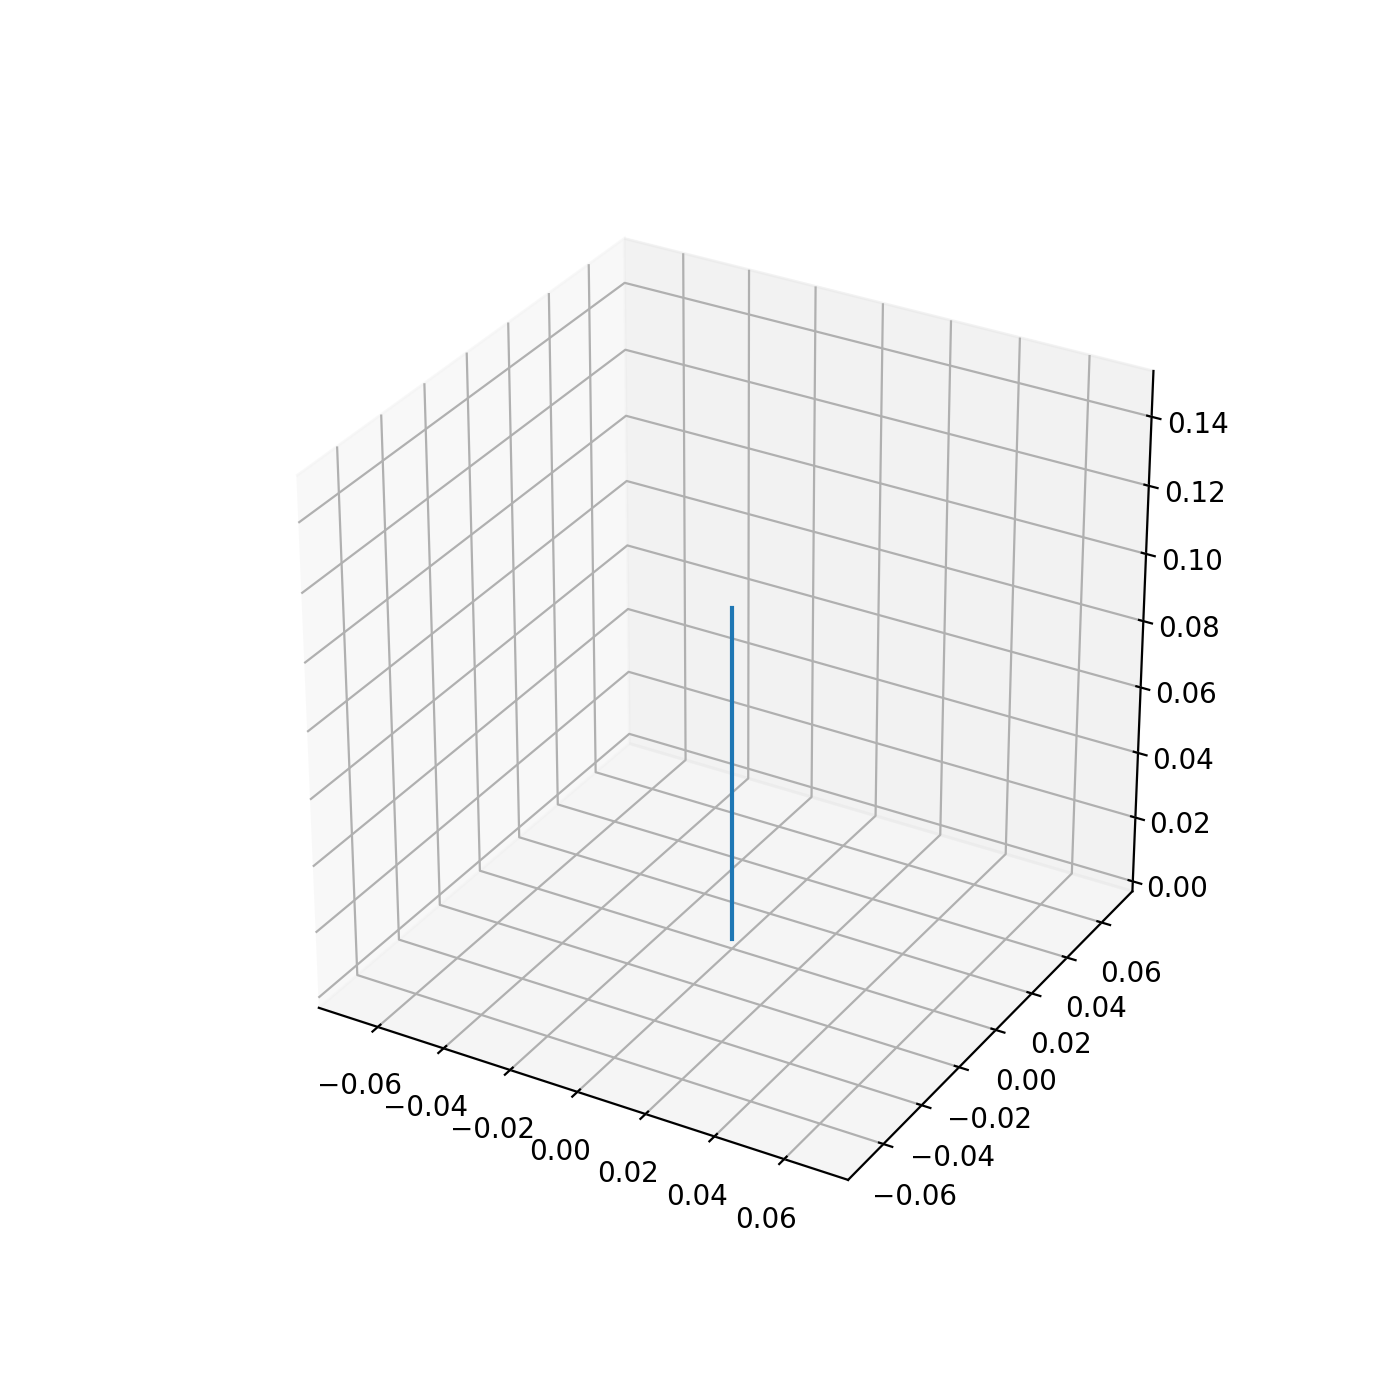

In [6]:
auxiliary.plot_centerline(centerline)

### Boundary conditions

The left end of the rod (i.e. s=0, node 0) is a Dirichlet boundary.

The right end of the rod (i.e. s=0.1, node `n_e = n_n-1`) is a Neumann boundary.

In [7]:
# force boundary condition at the right end (transverse load)
b1 = np.array([0, 1, 1, 0, 0, 0], dtype=float)

### Newton-Rhapson

In [91]:
def staticsolver(b1):
    
    # counting iterations
    iterations = 0 
    
    # displacement increment vector
    increments = np.zeros((6*n_n), dtype=float)
    
    # norm of global incremental displacement vector
    # to keep track of convergence
    increments_norm = 0

    # must be stored persistently, so we can use Simo's update formula
    second_strain_invariant = np.zeros((3, n_el), dtype=float)
    
    
    # norm of residual vector
    # to keep track of convergence
    residuals_norm = 0
    
    
    # empty array for logging transverse load (at s=1, in direction 2)
    #load_data = np.array([], dtype=float)
    
    # empty array for logging transverse displacement (at last node, in direction 2)
    #displacement_data = np.array([], dtype=float)
    
    
    # we start simulation without load and increase the load gradually
    # -> load-controlled Newton-Rhapson
    target_load = np.copy(b1)
    current_load = np.array([0,2.0,0,0,0,0]) #np.zeros_like(b1)
    
    # begin Newton-Rhapson iterations
    while(np.max(np.abs(target_load - current_load)) > 0.1):
        iterations += 1
    
        # display output
        #print('iteration', iteration)
        #print('increments_norm', increments_norm)
        #print('residuals_norm', residuals_norm)
        #print('transverse load', b1[1])
    
        # when converged, change of boundary condition (load control)
        if(increments_norm < 1e-4 and residuals_norm < 1e-4):

            # logging
            #load_data = np.append(load_data, b1[1])
            #displacement_data = np.append(displacement_data, centerline[1, -1])
            #??col   = [b1[1], z0[1, -1], b1[1]*L**3/(3*EI)]
            
            # increasing transverse load
            load_change = 0.1*np.sign(target_load - current_load)
            #load_change = 0.1*target_load
            current_load += load_change
            print('changed load by', load_change)
            
    
        if iterations % 16 == 0:
            print(target_load - current_load)
            print(residuals_norm)
        
        #plot3(z0(3,:),z0(1,:),z0(2,:));
        #pause(.001);
        
        increments_norm, residuals_norm = newton_iteration(centerline, rotation, 
                                                           increments, second_strain_invariant,
                                                           current_load)

    print('it took', iterations, 'iterations')
    #plot(data1(:,1),data1(:,2),'r');
    #plot(data1(:,1),data1(:,3),'b');
    #plt.plot(np.arange(len(load_data)), load_data)

### Linearizing and solving the linearized problem

In [18]:
@numba.jit(numba.types.UniTuple(numba.float64, 2)(numba.float64[:, :], numba.float64[:, :], numba.float64[:], numba.float64[:, :], numba.float64[:]), nopython=True)
def newton_iteration(centerline, rotation, increments, second_strain_invariant, current_load):
    
    # global residuals vector
    residuals = np.zeros((6*n_n), dtype=numba.float64)
    
    # global Jacobian matrix
    jac = np.zeros((6*n_n, 6*n_n), dtype=numba.float64) #numba.float64
    
    
    # iterating over all elements
    for i in range(1, n_n):
        
        # update configuration of element ...
        
        # update centerline at right node of element
        centerline[:, i] += increments[6*i:6*i+3]
        
        # update rotation at right node of element
        rotation[:, i] = rotations.update_euler(rotation[:, i], increments[6*i+3:6*i+6])
        
        if np.linalg.norm(rotation[:, i]) > np.pi:
            print('current rotation larger than pi')
        
        if np.linalg.norm(increments[6*i+3:6*i+6]) > np.pi:
            print('current incremental rotation larger than pi')
        
        
        # compute rotation matrix at midpoint of element ...
        
        # note that this interpolation is an approximation
#         mid_euler = (rotation[:, i-1] + rotation[:, i]) / 2
#         if np.linalg.norm(rotation[:, i] - rotation[:, i-1]) > np.pi:
#             # required because extracted axial vector may differ by 2*pi
#             print("a strange thing happened")
            
#             # this is a hack!
#             mid_euler = rotation[:, i-1]
#         R = rotations.matrix_from_euler(mid_euler)
        R = rotations.interpolate_euler(rotation[:, i-1], rotation[:, i])
        
        
        # compute first invariant strain measure in the element ...
        
        # compute translational displacement tangent vector
        h = h_vector[i-1]
        centerline_tangent = (centerline[:, i] - centerline[:, i-1]) / h
        
        # first invariant strain measure
        first_strain_invariant = np.dot(R.T, centerline_tangent)
        # no axial strain <=> lambda_3 = 1
        first_strain_invariant[2] -= 1
        
        
        
        # compute second invariant strain measure in the element using Simo's formula ...
        
        # incremental rotation tangent vector
        incremental_euler_tangent = (increments[6*i+3:6*i+6] - increments[6*(i-1)+3:6*(i-1)+6]) / h
        
        # incremental Euler vector at midpoint of element
        mid_incremental_euler = (increments[6*i+3:6*i+6] + increments[6*(i-1)+3:6*(i-1)+6]) / 2
        norm_of_mid_incremental_euler = np.linalg.norm(mid_incremental_euler)
        
        # compute beta
        if norm_of_mid_incremental_euler < 1e-6:
            # use asymptotic approximation of Simo's formula to save computational cost
            beta = incremental_euler_tangent + \
                   0.5*auxiliary.cross(mid_incremental_euler, incremental_euler_tangent)
        else:
            x = np.sin(norm_of_mid_incremental_euler) / norm_of_mid_incremental_euler
            delu = mid_incremental_euler / norm_of_mid_incremental_euler
            beta = x*incremental_euler_tangent + \
                   (1-x) * np.dot(delu.T, incremental_euler_tangent) * delu + \
                   2 * (np.sin(0.5*norm_of_mid_incremental_euler) / norm_of_mid_incremental_euler)**2 * auxiliary.cross(mid_incremental_euler, incremental_euler_tangent)
        
        # updating the second strain invariant
        second_strain_invariant[:, i-1] += np.dot(R.T, beta)
        
        
        
        # compute internal reactions in inertial frame of the element ...
        
        forces = np.dot(R, np.array([C[0, 0]*first_strain_invariant[0],
                                     C[1, 1]*first_strain_invariant[1],
                                     C[2, 2]*first_strain_invariant[2]]))
        
        moments = np.dot(R, np.array([C[3, 3]*second_strain_invariant[0, i-1],
                                      C[4, 4]*second_strain_invariant[1, i-1],
                                      C[5, 5]*second_strain_invariant[2, i-1]]))
        
        
        
        # add contriubutions of the element to residual vector ...
        
        # contributions from internal forces and moments
        crossphin = 0.5*h*auxiliary.cross(centerline_tangent, forces)
        residuals[6*(i-1):6*i] += np.hstack((-forces, -crossphin - moments))
        residuals[6*i:6*(i+1)] += np.hstack((+forces, -crossphin + moments))

        
        
        # add contributions of the element to Jacobian matrix ...              
        
        # ?? symmetrize?
        C11 = np.dot(np.dot(R, C[0:3, 0:3]), R.T)
        C11 = (C11 + C11.T) / 2
        C12 = np.dot(np.dot(R, C[0:3, 3:6]), R.T)
        C21 = C12.T
        C22 = np.dot(np.dot(R, C[3:6, 3:6]), R.T)
        C22 = (C22 + C22.T) / 2
        
        centerline_tangent_cross = auxiliary.skew_matrix_from_vector(centerline_tangent)
        forces_cross = auxiliary.skew_matrix_from_vector(forces)
        moments_cross = auxiliary.skew_matrix_from_vector(moments)

        # material tangent stiffness (symmetric part)
        jac[6*(i-1):6*i, 6*(i-1):6*i] += np.vstack((np.hstack((+C11 / h,
                                                               -0.5*np.dot(C11, centerline_tangent_cross) + C12 / h)),
                                                    np.hstack((-0.5*np.dot(centerline_tangent_cross.T, C11) + C21 / h,
                                                               np.dot(np.dot(centerline_tangent_cross.T, C11), centerline_tangent_cross)*(h / 3) - 0.5*np.dot(centerline_tangent_cross.T, C12) + np.dot(C21, centerline_tangent_cross) + C22 / h))))
        
        jac[6*i:6*(i+1), 6*i:6*(i+1)] += np.vstack((np.hstack((+C11 / h,
                                                               +0.5*np.dot(C11, centerline_tangent_cross) + C12 / h)),
                                                    np.hstack((+0.5*np.dot(centerline_tangent_cross.T, C11) + C21 / h,
                                                               np.dot(np.dot(centerline_tangent_cross.T, C11), centerline_tangent_cross)*(h / 3) + 0.5*np.dot(centerline_tangent_cross.T, C12) + np.dot(C21, centerline_tangent_cross) + C22 / h))))
        
        jac[6*i:6*(i+1), 6*(i-1):6*i] += np.vstack((np.hstack((-C11 / h,
                                                               +0.5*np.dot(C11, centerline_tangent_cross) - C12 / h)),
                                                    np.hstack((-0.5*np.dot(centerline_tangent_cross.T, C11) - C21 / h,
                                                               np.dot(np.dot(centerline_tangent_cross.T, C11), centerline_tangent_cross)*(h / 6) - 0.5*np.dot(centerline_tangent_cross.T, C12) - np.dot(C21, centerline_tangent_cross) - C22 / h))))
        
        jac[6*(i-1):6*i, 6*i:6*(i+1)] += np.vstack((np.hstack((-C11 / h,
                                                               -0.5*np.dot(C11, centerline_tangent_cross) - C12 / h)),
                                                    np.hstack((+0.5*np.dot(centerline_tangent_cross.T, C11) - C21 / h,
                                                               np.dot(np.dot(centerline_tangent_cross.T, C11), centerline_tangent_cross)*(h / 6) + 0.5*np.dot(centerline_tangent_cross.T, C12) - np.dot(C21, centerline_tangent_cross) - C22 / h))))
        
        # geometric tangent stiffness (non-symmetric)
        jac[6*(i-1):6*i, 6*(i-1):6*i] += np.vstack((np.hstack((np.zeros((3,3)), +0.5*forces_cross)),
                                                    np.hstack((-0.5*forces_cross, +0.5*moments_cross - np.dot(centerline_tangent_cross.T, forces_cross)*(h / 3)))))
        
        jac[6*i:6*(i+1), 6*i:6*(i+1)] += np.vstack((np.hstack((np.zeros((3,3)), -0.5*forces_cross)),
                                                    np.hstack((+0.5*forces_cross, -0.5*moments_cross - np.dot(centerline_tangent_cross.T, forces_cross)*(h / 3)))))
        
        jac[6*i:6*(i+1), 6*(i-1):6*i] += np.vstack((np.hstack((np.zeros((3,3)), -0.5*forces_cross)),
                                                    np.hstack((-0.5*forces_cross, -0.5*moments_cross - np.dot(centerline_tangent_cross.T, forces_cross)*(h / 6)))))
        
        jac[6*(i-1):6*i, 6*i:6*(i+1)] += np.vstack((np.hstack((np.zeros((3,3)), +0.5*forces_cross)),
                                                    np.hstack((+0.5*forces_cross, +0.5*moments_cross - np.dot(centerline_tangent_cross.T, forces_cross)*(h / 6)))))
        
        # tangent due to distributive load
        
        # tangent due to boundary loads
        
    
    # apply Neumann boundary conditions
    #residuals[0:6] += b0 # is a Dirichlet boundary
    # ?? in director basis
    residuals[-6:] -= current_load
    #print('applied', current_load)
                                                                                                                         
    # solve the linearized problem
    increments[6:] = np.linalg.solve(-jac[6:, 6:], residuals[6:])
                                                                                                             
    increments_norm = np.linalg.norm(increments[6:])
    
    # don't allow large increments                                                                                                                    
    if increments_norm > 1:
        increments[6:] = increments[6:] / increments_norm
    
    residuals_norm = np.linalg.norm(residuals[6:])

    return increments_norm, residuals_norm

In [94]:
centerline, rotation = set_initial_conditions()
b1 = np.array([0, 1, 0, 0, 0.0, 0.0], dtype=float)
%time staticsolver(b1)

changed load by [ 0.  -0.1  0.   0.   0.   0. ]
[ 0.  -0.9  0.   0.   0.   0. ]
0.05241177894188278
[ 0.  -0.9  0.   0.   0.   0. ]
0.00023011366583812118
changed load by [ 0.  -0.1  0.   0.   0.   0. ]
[ 0.  -0.8  0.   0.   0.   0. ]
0.006354830768355305
changed load by [ 0.  -0.1  0.   0.   0.   0. ]
[ 0.  -0.7  0.   0.   0.   0. ]
0.04194345398042717
changed load by [ 0.  -0.1  0.   0.   0.   0. ]
[ 0.  -0.6  0.   0.   0.   0. ]
2.6252725233097713
[ 0.  -0.6  0.   0.   0.   0. ]
0.00012547261758420034
changed load by [ 0.  -0.1  0.   0.   0.   0. ]
[ 0.  -0.5  0.   0.   0.   0. ]
0.005628007941752336
changed load by [ 0.  -0.1  0.   0.   0.   0. ]
[ 0.  -0.4  0.   0.   0.   0. ]
0.042084830298674464
changed load by [ 0.  -0.1  0.   0.   0.   0. ]
[ 0.  -0.3  0.   0.   0.   0. ]
0.1327489927781666
changed load by [ 0.  -0.1  0.   0.   0.   0. ]
[ 0.  -0.2  0.   0.   0.   0. ]
5.269494716344776e-05
[ 0.  -0.2  0.   0.   0.   0. ]
0.003180699562711739
changed load by [ 0.  -0.1  0.   0

<IPython.core.display.Javascript object>


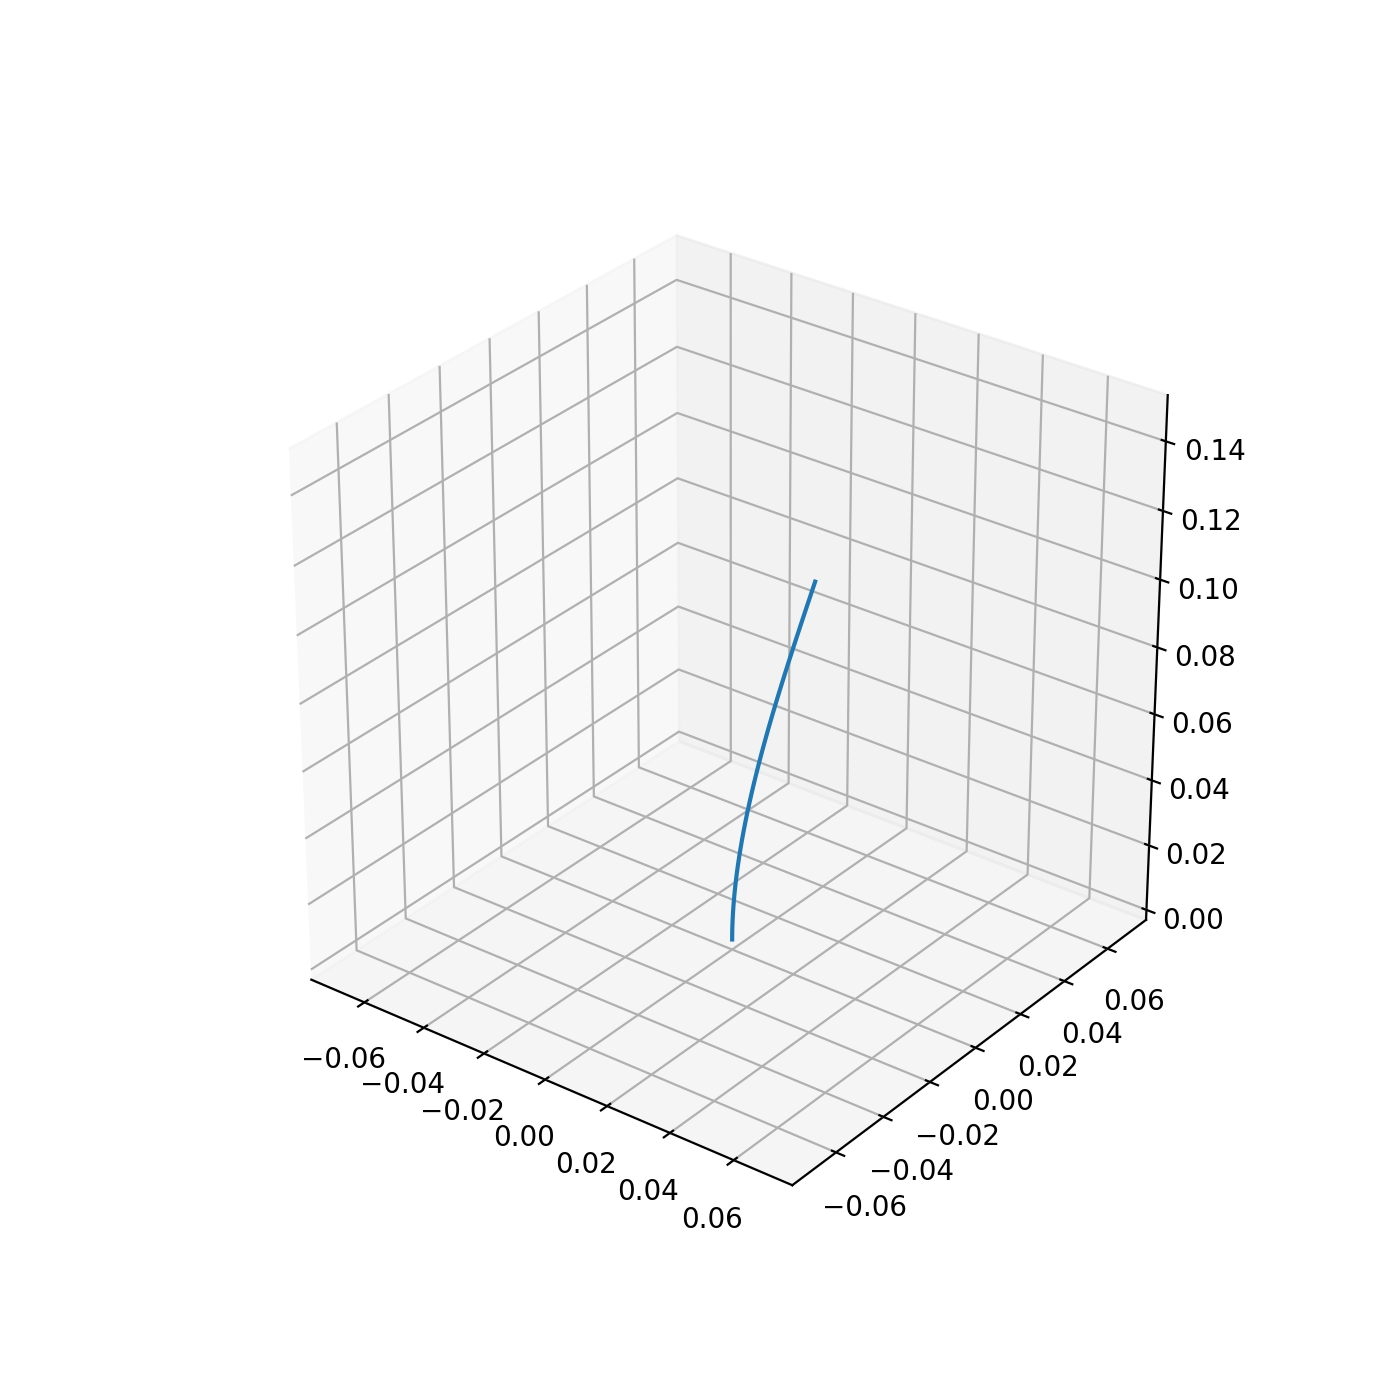

In [95]:
auxiliary.plot_centerline(centerline)

In [62]:
print(centerline[:, n_el], rotation[:, n_el])

[ 0.00076931 -0.00659473  0.0708849 ] [-0.7412403  -0.61912336 -2.06050752]
